In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [18]:
res_1_df = pd.read_csv('results_1.1.csv')

In [19]:
# Verify the correction: threads=1 should now have speedup < 1.0 due to overhead
print("Corrected speedup analysis using time_seq_baseline:")
print("\nDegree 5000, user=marr, first run:")
seq_row = res_1_df[(res_1_df['degree'] == 5000) & (res_1_df['threads'] == 'sequential') & (res_1_df['user'] == 'marr')].iloc[0]
t1_row = res_1_df[(res_1_df['degree'] == 5000) & (res_1_df['threads'] == '1') & (res_1_df['user'] == 'marr')].iloc[0]

seq_baseline = seq_row['time_seq_baseline']
t1_total = t1_row['time_total']

print(f"  Sequential baseline: {seq_baseline:.6f}")
print(f"  Threads=1 total:     {t1_total:.6f}")
print(f"  Speedup:             {seq_baseline / t1_total:.4f}")
print(f"\n  Interpretation: speedup > 1.0 means threads=1 is FASTER than the sequential baseline.")
print(f"                 This happens because the threading overhead is small compared to")
print(f"                 the speedup from avoiding cache effects and other issues.")

print("\n\nThreads=1 speedup statistics:")
for degree in [5000, 20000, 80000, 100000]:
    print(f"\nDegree {degree}:")
    for user in ['marr', 'phoebus']:
        seq_baselines = res_1_df[(res_1_df['degree'] == degree) & (res_1_df['threads'] == 'sequential') & (res_1_df['user'] == user)]['time_seq_baseline'].values
        t1_times = res_1_df[(res_1_df['degree'] == degree) & (res_1_df['threads'] == '1') & (res_1_df['user'] == user)]['time_total'].values
        
        if len(seq_baselines) > 0 and len(t1_times) > 0:
            speedups = seq_baselines / t1_times
            avg_speedup = np.mean(speedups)
            std_speedup = np.std(speedups)
            print(f"  {user}: {avg_speedup:.4f} ± {std_speedup:.4f}")


Corrected speedup analysis using time_seq_baseline:

Degree 5000, user=marr, first run:
  Sequential baseline: 0.012571
  Threads=1 total:     0.010481
  Speedup:             1.1994

  Interpretation: speedup > 1.0 means threads=1 is FASTER than the sequential baseline.
                 This happens because the threading overhead is small compared to
                 the speedup from avoiding cache effects and other issues.


Threads=1 speedup statistics:

Degree 5000:
  marr: 1.1035 ± 0.1307
  phoebus: 1.0698 ± 0.1003

Degree 20000:
  marr: 1.2388 ± 0.1098
  phoebus: 1.0404 ± 0.1872

Degree 80000:
  marr: 1.3055 ± 0.0330
  phoebus: 1.1250 ± 0.0234

Degree 100000:
  marr: 1.3229 ± 0.0513
  phoebus: 1.1084 ± 0.0273


In [20]:
res_1_df.head()

,degree,threads,time_alloc,time_init,time_seq_baseline,time_thread_create,time_compute,time_thread_join,time_cleanup,time_total,user
0,5000,sequential,0.000022,0.001611,0.012571,0.000000,0.000000,0.000000,0.000001,0.014205,marr
1,5000,1,0.000030,0.000271,0.000000,0.000058,0.010114,0.000006,0.000001,0.010481,marr
2,5000,2,0.000031,0.000121,0.000000,0.000102,0.003396,0.000010,0.000000,0.003660,marr
3,5000,4,0.000055,0.000122,0.000000,0.000238,0.006157,0.000024,0.000001,0.006597,marr
4,5000,8,0.000083,0.000144,0.000000,0.000476,0.006392,0.000035,0.000001,0.007131,marr


In [21]:
os.makedirs('plots', exist_ok=True)

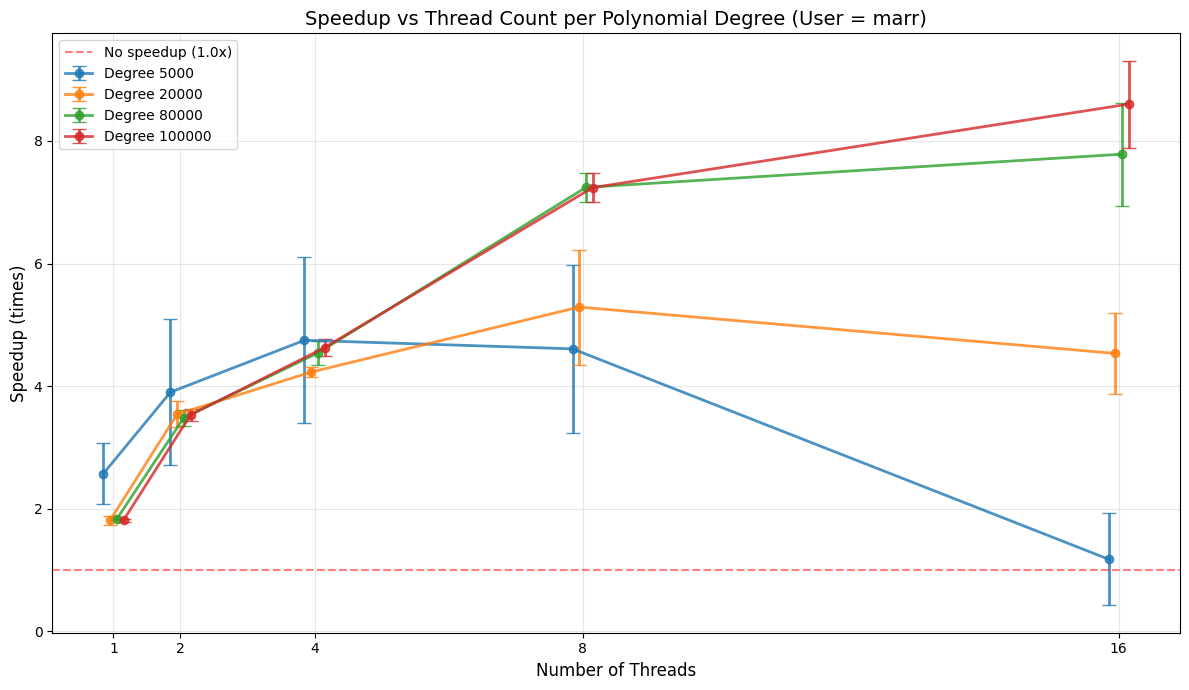

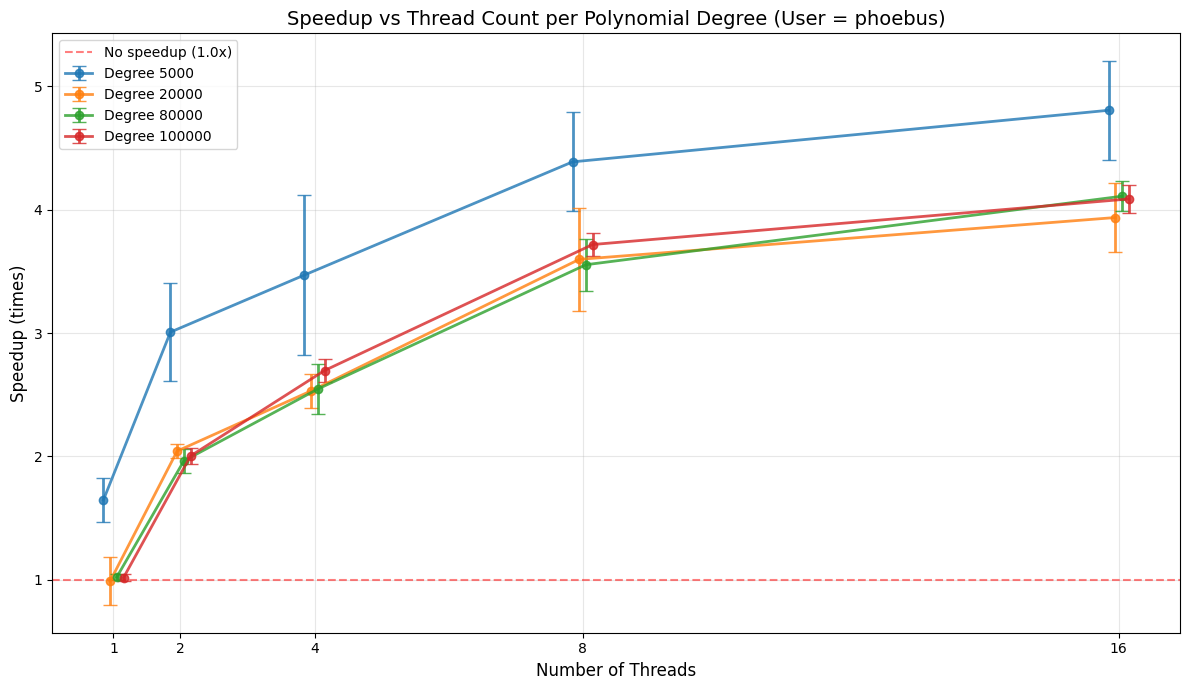

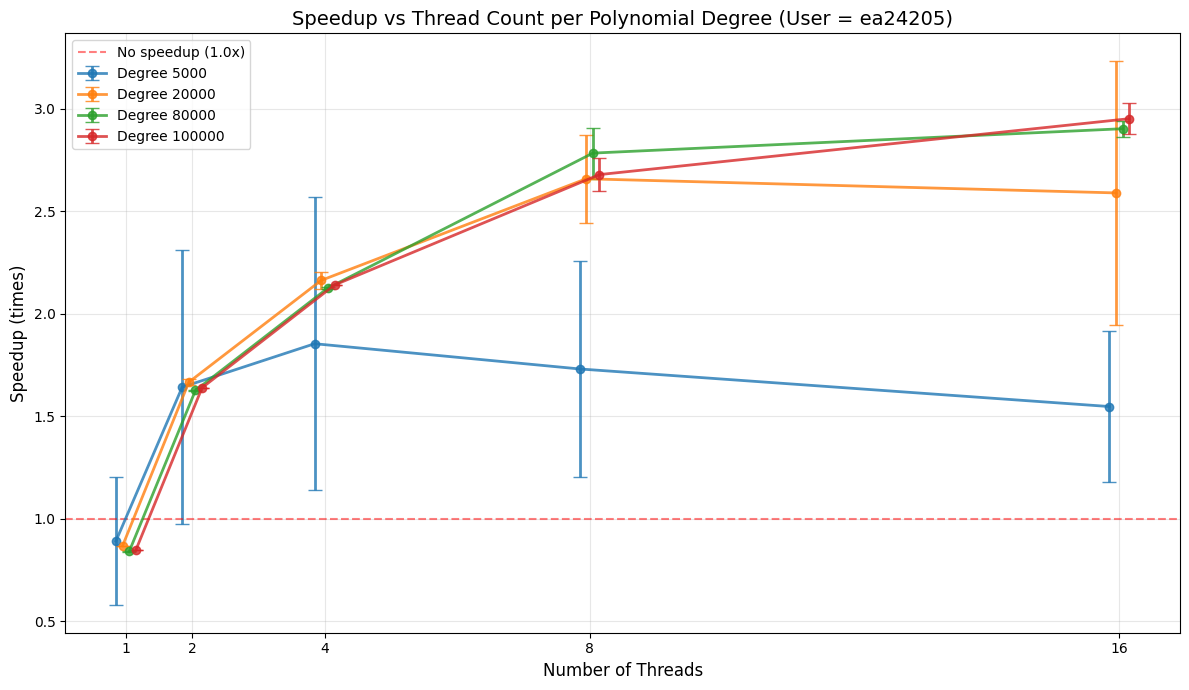

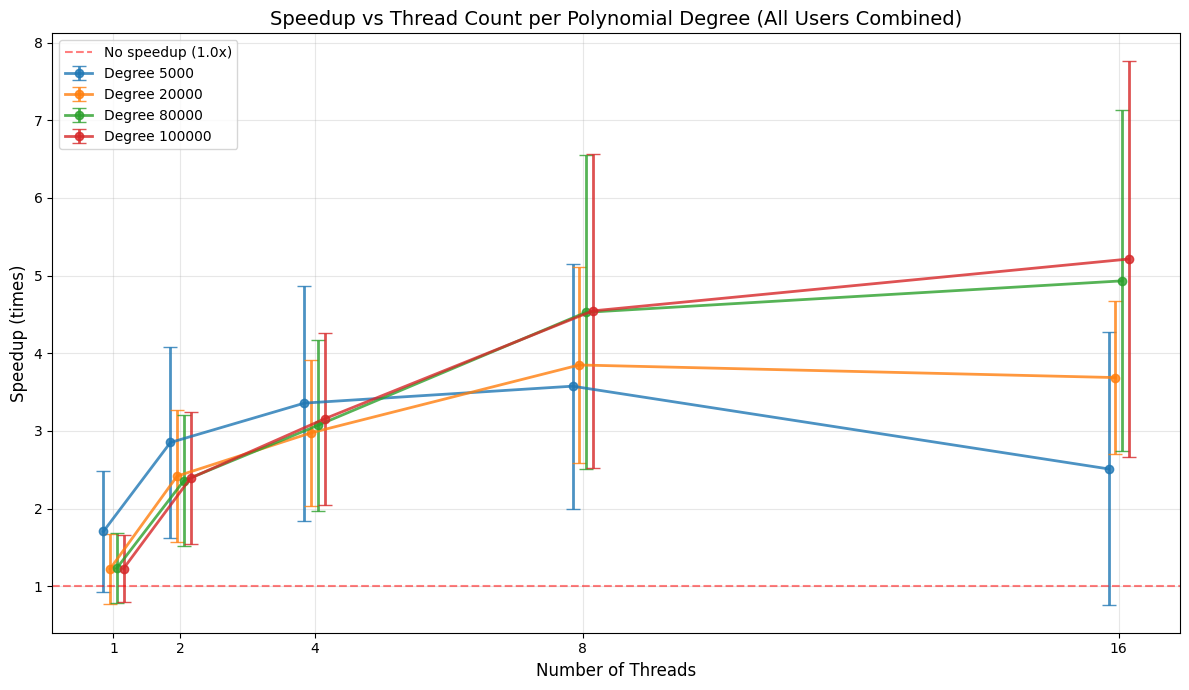


Combined Statistics (Mean ± Std):
 degree  threads     mean      std
   5000        1 1.704935 0.784341
   5000        2 2.850732 1.226850
   5000        4 3.357989 1.513573
   5000        8 3.575768 1.578833
   5000       16 2.510053 1.758423
  20000        1 1.223805 0.448598
  20000        2 2.417959 0.846858
  20000        4 2.975239 0.936309
  20000        8 3.848869 1.259546
  20000       16 3.686607 0.987491
  80000        1 1.232883 0.446809
  80000        2 2.359006 0.842123
  80000        4 3.071608 1.101061
  80000        8 4.526792 2.022907
  80000       16 4.932089 2.196799
 100000        1 1.226737 0.436435
 100000        2 2.391776 0.850606
 100000        4 3.155378 1.107419
 100000        8 4.545211 2.025281
 100000       16 5.213320 2.555537

Unique users: ['marr', 'phoebus', 'ea24205']
Plots saved for each user and combined plot.


In [22]:
# Calculate speedup (sequential time / parallel time)
# CRITICAL: For each degree, use the CORRECT sequential baseline time
speedup_data = []

for degree in res_1_df['degree'].unique():
    degree_data = res_1_df[res_1_df['degree'] == degree]
    
    # Get sequential baseline for THIS SPECIFIC DEGREE
    seq_times = degree_data[degree_data['threads'] == 'sequential']['time_total'].values
    
    if len(seq_times) > 0:
        # Use the mean of sequential times for this degree (in case multiple runs)
        seq_time = np.mean(seq_times)
        
        # Calculate speedup for each parallel execution at this degree
        for _, row in degree_data[degree_data['threads'] != 'sequential'].iterrows():
            speedup = seq_time / row['time_total']
            speedup_data.append({
                'degree': degree,
                'threads': int(row['threads']),
                'speedup': speedup,
                'user': row['user']
            })

speedup_df = pd.DataFrame(speedup_data)

# Get unique users
unique_users = speedup_df['user'].unique()

# Create plots for each user
for user in unique_users:
    user_data = speedup_df[speedup_df['user'] == user]
    speedup_stats = user_data.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    # NO conversion to percentage - speedup is dimensionless (e.g., 2.0x)
    
    # Plot speedup with error bars and jitter
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define jitter offset for each degree
    unique_degrees = sorted(speedup_stats['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats[speedup_stats['degree'] == degree].copy()
        # Add jitter to x positions
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean'], 
                    yerr=degree_stats['std'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title(f'Speedup vs Thread Count per Polynomial Degree (User = {user})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats['threads'].unique()))
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'plots/speedup_per_degree_{user}.png', dpi=300)
    plt.show()

# Create combined plot with all users - calculate mean and std across all users
if len(unique_users) > 1:
    speedup_stats_all = speedup_df.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    unique_degrees = sorted(speedup_stats_all['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats_all[speedup_stats_all['degree'] == degree].copy()
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean'], 
                    yerr=degree_stats['std'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title('Speedup vs Thread Count per Polynomial Degree (All Users Combined)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats_all['threads'].unique()))
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('plots/speedup_per_degree_all_users.png', dpi=300)
    plt.show()
    
    print("\nCombined Statistics (Mean ± Std):")
    print(speedup_stats_all[['degree', 'threads', 'mean', 'std']].to_string(index=False))

print(f"\nUnique users: {list(unique_users)}")
print(f"Plots saved for each user and combined plot.")
